In [76]:
import pandas as pd
from collections import defaultdict
import numpy as np
from rdkit.Chem import MolFromSmiles, MolToSmiles
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
mix_df = pd.read_csv("mixture_smi_definitions_clean.csv")
gslf_df = pd.read_csv("../gs-lf/gs-lf_combined.csv")
snitz_3_df = pd.read_csv("snitz3_jaccard.csv")

In [33]:
def transform_dataframe(df):
    # Create a dictionary to store unique SMILES and their sources
    smiles_dict = defaultdict(list)
    
    # Iterate through the DataFrame
    for _, row in df.iterrows():
        dataset = row['Dataset']
        mixture_label = row['Mixture Label']
        source = f"{dataset}_{mixture_label}"
        
        # Check all smi_n columns
        for col in df.columns:
            if col.startswith('smi_'):
                smiles = row[col]
                if pd.notna(smiles):  # Check if the SMILES is not NaN
                    smiles_dict[smiles].append(source)
    
    # Create the new DataFrame
    new_df = pd.DataFrame({
        'SMILES': list(smiles_dict.keys()),
        'Sources': [','.join(sources) for sources in smiles_dict.values()]
    })
    
    return new_df

In [63]:
mix_df = mix_df[mix_df['Dataset'] == 'Snitz 3'].copy()

In [64]:
mix_smi_df = transform_dataframe(mix_df)
mix_smi_df['canonical_smiles'] = mix_smi_df.apply(lambda row: MolToSmiles(MolFromSmiles(row['SMILES'])), axis=1)
gslf_df['canonical_smiles'] = gslf_df.apply(lambda row: MolToSmiles(MolFromSmiles(row['IsomericSMILES'])), axis=1)

merged_df = pd.merge(mix_smi_df, gslf_df, on='canonical_smiles', how='left')

In [66]:
def calculate_jaccard_distances(df, start_col=6):
    # Select columns from start_col to the end
    selected_columns = df.iloc[:, start_col:]
    
    # Identify rows with NaN values
    rows_with_nan = selected_columns.isna().any(axis=1)
    
    # Convert to binary (presence/absence) matrix, treating NaN as absence
    binary_matrix = (selected_columns.notna() & (selected_columns != 0)).astype(int)
    
    # Calculate pairwise Jaccard distances
    jaccard_distances = pdist(binary_matrix, metric='jaccard')
    
    # Convert distance vector to a square matrix
    jaccard_matrix = squareform(jaccard_distances)
    
    # Create a mask for rows and columns with NaN
    nan_mask = rows_with_nan.values[:, np.newaxis] | rows_with_nan.values
    
    # Apply the mask to the jaccard_matrix
    jaccard_matrix[nan_mask] = np.nan
    
    # Create a DataFrame with row and column labels
    jaccard_df = pd.DataFrame(jaccard_matrix, index=df.index, columns=df.index)
    
    return jaccard_df, jaccard_matrix.flatten()

In [69]:
jaccard_df, jaccard_distances = calculate_jaccard_distances(merged_df)

In [73]:
snitz_3_df['GSLF Jaccard'] = snitz_3_df.apply(lambda row: jaccard_df[row['Mixture 1 ID']-1][row['Mixture 2 ID']-1], axis=1)

Text(0.5, 1.0, 'Augmented GSLF Jaccard vs Single Molecular Similarity')

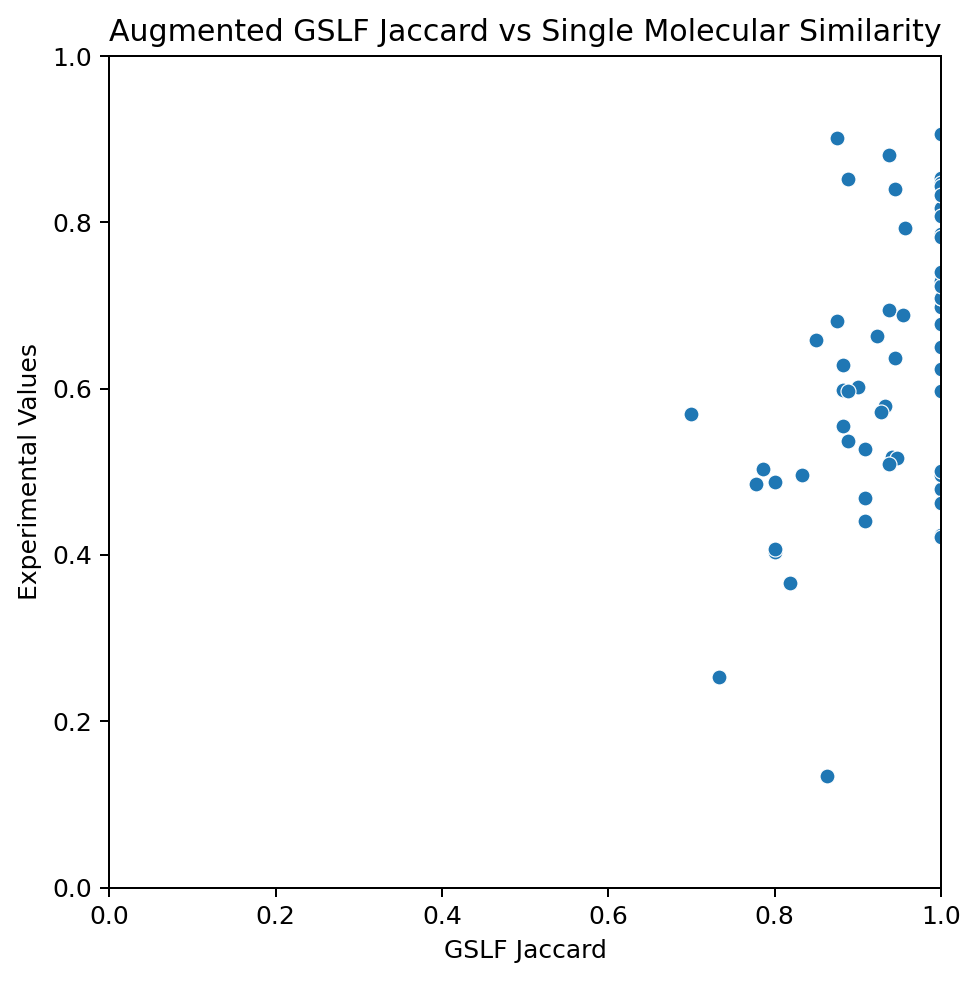

In [83]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
g = sns.scatterplot(x='GSLF Jaccard', y='Experimental Values', data=snitz_3_df, ax=ax)
ax.set_aspect('equal')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_title('Augmented GSLF Jaccard vs Single Molecular Similarity')